<ipython-input-4-c08644c4e06b>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_coordinate[f'{column}_rad'] = rad


['London', 'Lambeth', 'Brixton', 'Streatham', 'Thornton Heath', 'Croydon', 'Shirley', 'West Wickham', 'Hayes', 'Farnborough', 'Sevenoaks', 'Tonbridge', 'Paddock Wood', 'Cranbrook', 'Tenterden', 'Rye', 'Lydd', 'Hythe', 'Folkestone', 'Boulogne-sur-Mer', 'Calais', 'Dunkerque', 'Veurne', 'Oudenburg', 'Bruges', 'Eeklo', 'Gent', 'Lokeren', 'Sint-Niklaas', 'Antwerp', 'Hoogstraten', '’s-Hertogenbosch', 'Utrecht', 'Lelystad', 'Zwolle', 'Neuenhaus', 'Lingen', 'Haselünne', 'Löningen', 'Werlte', 'Friesoythe', 'Oldenburg', 'Elsfleth', 'Brake', 'Bremerhaven', 'Bederkesa', 'Cuxhaven', 'Marne', 'Heide', 'Husum', 'Schleswig', 'Kappeln', 'Svendborg', 'Sorø', 'Copenhagen', 'Hjärup', 'Kristianstad', 'Kalmar', 'Visby', 'Nyköping', 'Stockholm', 'Uppsala', 'Gävle', 'Bollnäs', 'Härnösand', 'Örnsköldsvik', 'Umeå', 'Skellefteå', 'Luleå', 'Tornio', 'Rovaniemi', 'Sodankylä', 'Kovdor', 'Kandalaksha', 'Umba', 'Kem', 'Belomorsk', 'Onega', 'Mirnyy', 'Nyandoma', 'Velsk', 'Totma', 'Chukhloma', 'Neya', 'Sharya', 'Vetlug

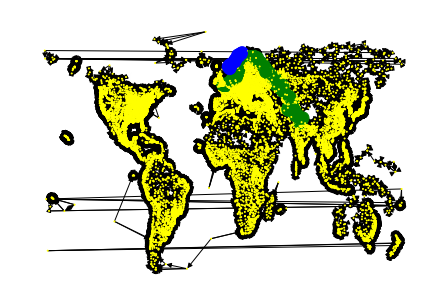

In [4]:
import pandas as pd
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
from sklearn.neighbors import BallTree

città_mondo = pd.read_excel(r"C:\Users\Avion\PycharmProjects\80giorno_progetto\worldcities.xlsx")

class Grafo():

    def __init__(self, dataframe):
        self.df = dataframe
        self.df_coordinate = pd.DataFrame()
        self.posizione_dizionario = {}
        self.grafo_città = nx.MultiDiGraph()
        self.grafo_indiretto = nx.Graph()
        self.viaggio = []
        self.viaggio_città = []
        self.viaggio_città_stato = []
        self.lista_edges = []
        self.df_nodi_vicini = pd.DataFrame()
        self.città_indice = città_mondo.set_index('id')
        self.df_nodi_vicini_indice = pd.DataFrame()

    def calcola_coordinate(self):
        self.df_coordinate = self.df[["lat","lng"]]

        #Converto le coordinate in radianti
        for column in self.df_coordinate[["lat", "lng"]]:
            rad = np.deg2rad(self.df_coordinate[column].values)
            self.df_coordinate[f'{column}_rad'] = rad

        self.df_coordinate = self.df_coordinate[["lat_rad","lng_rad"]]
        self.df_coordinate = np.array(self.df_coordinate)

    def costruisci_grafo(self):
        #Aggiungo i nodi
        for i,y in città_mondo.iterrows():
            self.grafo_città.add_node(y[10], pos=(y[3],y[2]), country= y[5])
            self.posizione_dizionario[y[10]] = (y[3],y[2])

        #Calcolo i tre nodi più vicini a ciascun nodo
        tree = BallTree(self.df_coordinate,leaf_size=30000, metric= 'haversine')
        dist, ind = tree.query(self.df_coordinate, k=4)
        lista_nomi_nodi = città_mondo.iloc[:,10]
        self.df_nodi_vicini = pd.DataFrame(ind, columns=("1","Città1", "Città2", "Città3"))
        self.df_nodi_vicini.drop('1', 1, inplace=True)
        for i in self.df_nodi_vicini.values:
            for j in i:
                if j < 50000:
                    self.df_nodi_vicini.replace(j, città_mondo.iloc[j][10], inplace=True)
        arr = self.df["id"].tolist()
        self.df_nodi_vicini_indice = self.df_nodi_vicini.set_axis(arr, axis='index')

        #Aggiungo i vertici
        n=0
        for i in lista_nomi_nodi:
            for j in self.df_nodi_vicini.iloc[n,:]:
                self.lista_edges.append((i,j))
            n+=1
        self.grafo_città.add_edges_from(self.lista_edges)

    def calcola_viaggio(self, partenza,arrivo):
        #Ottengo il grafo indiretto
        for i, y in città_mondo.iterrows():
            self.grafo_indiretto.add_node(y[10], pos=(y[3], y[2]), country=y[5])
        self.grafo_indiretto.add_edges_from(self.lista_edges)

        #Calcolo il viaggio più breve tra i due nodi (se possibile)
        if (partenza in self.città_indice.index) == False:
            print('ID partenza non valido')
        elif (arrivo in self.città_indice.index) == False:
            print('ID arrivo non valido')
        else:
            try:
                self.viaggio = nx.shortest_path(self.grafo_indiretto, source=partenza, target=arrivo)
                durata = 0
                for i in self.viaggio:
                    nome_città = self.città_indice['city'][i]
                    self.viaggio_città.append(nome_città)
                print(self.viaggio_città)
                for i in range(len(self.viaggio) - 1):
                    if self.df_nodi_vicini_indice['Città1'][self.viaggio[i]] == self.viaggio[i + 1]:
                        durata += 2
                    elif self.df_nodi_vicini_indice['Città2'][self.viaggio[i]] == self.viaggio[i + 1]:
                        durata += 4
                    elif self.df_nodi_vicini_indice['Città3'][self.viaggio[i]] == self.viaggio[i + 1]:
                        durata += 8
                    else:
                        durata += 16
                    if self.città_indice['country'][self.viaggio[i]] != self.città_indice['country'][self.viaggio[i + 1]]:
                        durata += 2
                    if self.città_indice['population'][self.viaggio[i + 1]] > 200000:
                        durata += 2
                print(('Il viaggio da {} a {} è durato {} ore').format(self.viaggio_città[0], self.viaggio_città[-1],durata))
            except:
                nome_partenza = self.città_indice['city'][partenza]
                nome_arrivo = self.città_indice['city'][arrivo]
                print(('Il viaggio da {} a {} non è possibile').format(nome_partenza, nome_arrivo))

    def calcola_tragitto(self,country,partenza,arrivo):
        Grafo.calcola_coordinate(self)
        Grafo.costruisci_grafo(self)
        Grafo.calcola_viaggio(self,partenza,arrivo)
        if (country in self.df.iso2.values) == False:
            print('Codice ISO2 non valido')
            longest = []
        else:
            #Prendo i nodi delle città dello stato scelto
            nodes_country = []
            for (p, d) in self.grafo_città.nodes(data=True):
                if d['country'] == country:
                    nodes_country.append(p)

            #Calcolo alcuni dei possibili tragitti
            q=0
            lista_tratti= []
            while(q<1000):
                try:
                    a = random.choice(nodes_country)
                    b = random.choice(nodes_country)
                    tratto = nx.shortest_path(self.grafo_città, source=a, target=b)
                    lista_tratti.append(tratto)
                    q += 1
                except:
                    pass
            lista_tratti.sort(key = len)
            longest=lista_tratti[-1]
            for i in longest:
                nome_città_ = self.città_indice['city'][i]
                self.viaggio_città_stato.append(nome_città_)
            print(self.viaggio_città_stato)

            # Calcolo la durata
            durata = 0
            for i in range(len(longest) - 1):
                if self.df_nodi_vicini_indice['Città1'][longest[i]] == longest[i + 1]:
                    durata += 2
                elif self.df_nodi_vicini_indice['Città2'][longest[i]] == longest[i + 1]:
                    durata += 4
                elif self.df_nodi_vicini_indice['Città3'][longest[i]] == longest[i + 1]:
                    durata += 8
                if self.città_indice['country'][longest[i]] != self.città_indice['country'][longest[i + 1]]:
                    durata += 2
                if self.città_indice['population'][longest[i + 1]] > 200000:
                    durata += 2
            print(('Il viaggio da {} a {} è durato {} ore').format(self.viaggio_città_stato[0], self.viaggio_città_stato[-1], durata))

        #Distinguo i nodi per colore e dimensione
        color_map = []
        size_node = []
        for nodes in self.grafo_città:
                if nodes in longest:
                    color_map.append('blue')
                    size_node.append(150)
                elif nodes in self.viaggio:
                    color_map.append('green')
                    size_node.append(150)
                else:
                    color_map.append('yellow')
                    size_node.append(1)

        #Disegno il grafo ottenuto
        nx.draw(self.grafo_città, node_color=color_map, pos= self.posizione_dizionario, node_size= size_node)
        plt.show()

grafo_stato = Grafo(dataframe = città_mondo)
grafo_stato.calcola_tragitto(country= 'NO', partenza= 1826645935 ,arrivo= 1356872604)